In [2]:
import sys #updated 2022_1_12
sys.path.append("/Users/yzhiyuan/workspace/DENV_10X/notebook/")  # go to parent dir
import lib.util
from lib.util import *

In [29]:
def reorg_celltype(adata):
    adata.obs.cell_type_new.cat.add_categories(['T cells', 'NK cells', 'B cells'], inplace = True)
    adata.obs.loc[((adata.obs.cell_subtype_new == 'CD4+ T cells') |
                            (adata.obs.cell_subtype_new == 'CD8+ effector T cells') |
                            (adata.obs.cell_subtype_new == 'CD8+ naive/memory T cells')), 'cell_type_new'] = 'T cells'
    
    adata.obs.loc[((adata.obs.cell_subtype_new == 'XCL_high NK cells') |
                            (adata.obs.cell_subtype_new == 'XCL_low NK cells')), 'cell_type_new'] = 'NK cells'
    
    adata.obs.loc[adata.obs.cell_type_new == 'B_cells', 'cell_type_new'] = 'B cells'
    
    adata.obs.cell_type_new.cat.remove_categories(['NK/T_cells', 'B_cells'], inplace = True)
    
    
    group_order_primary = ['B cells', 'Plasmablasts', 'T cells', 'NK cells', 'Monocytes', 'conventional DCs', 'plasmacytoid DCs', 
                'megakaryocytes']
    adata.obs.cell_type_new.cat.reorder_categories(group_order_primary, inplace = True)
    
    
    
    
    adata.obs.cell_subtype_new.cat.add_categories(['proliferating plasmablasts', 
                                                   'non-proliferating plasmablasts', 
                                                   'non-classical monocytes',
                                                   'intermediate monocytes'], inplace = True)
    
    
    
    adata.obs.loc[adata.obs.cell_subtype_new == 'cycling Plasmablasts', 
                  'cell_subtype_new'] = 'proliferating plasmablasts'
    adata.obs.loc[adata.obs.cell_subtype_new == 'non_cycling Plasmablasts', 
                  'cell_subtype_new'] = 'non-proliferating plasmablasts' 
    adata.obs.loc[adata.obs.cell_subtype_new == 'non_classical monocytes', 
                  'cell_subtype_new'] = 'non-classical monocytes'
    adata.obs.loc[adata.obs.cell_subtype_new == 'macrophages', 
                  'cell_subtype_new'] = 'intermediate monocytes'
    
    adata.obs.cell_subtype_new.cat.remove_categories(['cycling Plasmablasts', 
                                                   'non_cycling Plasmablasts',
                                                   'non_classical monocytes',
                                                   'macrophages'], inplace = True)
    
    
    
    
    group_order_secondary = ['memory B cells',
       'naive B cells', 'activated B cells', 'proliferating plasmablasts',
       'non-proliferating plasmablasts', 'CD4+ T cells', 'CD8+ effector T cells', 
        'CD8+ naive/memory T cells', 'XCL_high NK cells', 'XCL_low NK cells',
       'classical monocytes', 'non-classical monocytes', 'intermediate monocytes',
        'conventional DCs', 'plasmacytoid DCs', 'megakaryocytes']
    
    adata.obs.cell_subtype_new.cat.reorder_categories(group_order_secondary, inplace = True)


def info_df(adata):
    #initiate dataframe
    index = adata[adata.obs.Condition != 'Healthy'].obs.ID.unique()
    col = adata.obs.cell_type_new.unique()
    df = pd.DataFrame(index=index, columns=col)
    df.loc[:,:] = 0 
    
    #count virus_harboring cells in each cell type
    adata_virus = adata[adata.obs.DENV_reads != 0]
    for ct in col:
        temp = adata_virus[adata_virus.obs.cell_type_new == ct].obs.ID.value_counts()
        df.loc[temp.index, ct] = temp
    df['cell_sum'] = df.sum(axis = 1)
        
    df.loc[adata.obs[adata.obs.Condition == 'DWS'].ID.unique(), 'Condition'] = 'DWS'
    df.loc[adata.obs[adata.obs.Condition == 'dengue'].ID.unique(), 'Condition'] = 'dengue'
    df.loc[adata.obs[adata.obs.Condition == 'S_dengue'].ID.unique(), 'Condition'] = 'S_dengue'
    
#     df.drop(columns = ['unhealthy_cells', 'Platelets'],inplace=True)
    
    return(df)

def stackplot(df, path, name):
    rcParams['figure.figsize']=(6, 6)
    rcParams['font.size']= 16
    rcParams['axes.titlesize'] = 20
    rcParams['axes.labelsize'] = 20
    rcParams['pdf.fonttype'] = 42
    
    df['Condition'] = df['Condition'].astype('category')
    df['Condition'].cat.set_categories(['S_dengue', 'dengue', 'DWS'], inplace=True)
    df = df.sort_values(by = ['Condition','cell_sum'], ascending = False)
    df = df.loc[df.cell_sum != 0]
    
    df_temp = df.drop(columns = ['cell_sum', 'Condition'])
    fig, ax = plt.subplots()
    df_temp.plot(kind='bar', stacked=True, ax =ax)
    
    ax.set_xlabel('sample')
    ax.set_ylabel('cell_number')
    ax.set_title('DENV harboring cells')
    ax.tick_params(labelsize = 14, axis = 'x', rotation = 45)
    ax.tick_params(labelsize = 14, axis = 'y')
    
    filename = os.path.join(path, name)
    fig.savefig(filename, bbox_inches = 'tight')
    
def df_info_process(df, adata):
    df_temp = df.loc[(df.Condition == 'DWS') & (df.cell_sum > 100), :].iloc[:,:-2]
    
    df_total_temp = pd.DataFrame(index = (df_temp.index + '-total'), columns = df_temp.columns)
    for ID in df_total_temp.index:
        for cell_type in df_total_temp.columns:
            df_total_temp.loc[ID, cell_type] = len(adata.obs.loc[(adata.obs.ID == ID.split('-')[0]) & 
                                                            (adata.obs.cell_type_new == cell_type)].index)
            
    
    df_temp = df_temp.T
    df_temp['top3_sum'] = df_temp.sum(axis = 1)
    df_total_temp = df_total_temp.T
    df_total_temp['top3_sum-total'] = df_total_temp.sum(axis = 1)
    
    df_merge = pd.concat([df_temp, df_total_temp], axis = 1)
    
    df_merge.loc[:, 'ratio'] = (df_merge.loc[:, 'top3_sum'] / df_merge.loc[:, 'top3_sum-total'])*100
    for ind in df_merge.index:
        df_merge.loc[ind, 'text'] = '{}/{}'.format(df_merge.loc[ind, 'top3_sum'].astype('int'), 
                                                   df_merge.loc[ind, 'top3_sum-total'].astype('int'))
    df_merge.loc[:, 'celltype'] = df_merge.index
    df_merge = df_merge.sort_values(by = 'top3_sum', ascending = False)
    
#     df_ratio = df_temp / df_total_temp
    
    return(df_merge)

def fraction_plotting(df, path, name):
    #Plotting for cell fraction

    rcParams['figure.figsize']=(6, 6)
    rcParams['font.size']= 22
    rcParams['axes.titlesize'] = 20
    rcParams['axes.labelsize'] = 22
    rcParams['pdf.fonttype'] = 42
    
    fig, ax = plt.subplots()

    sb.barplot(data=df, x='ratio', y='celltype', ax=ax)

    n = 0
    celltype = list(df.index)
    for p in ax.patches:
        _x = p.get_x() + p.get_width() + float(0.3)
        _y = p.get_y() + p.get_height() / 2
        value = df.loc[celltype[n], 'text']
        ax.text(_x, _y, value, ha="left")
        n = n + 1

    ax.set_xlim(0,70)
    ax.set_ylabel('cell type')
    ax.set_xlabel('% cells with DENV RNA')
    ax.set_title('')

    ax.tick_params(labelsize = 20, axis = 'x')
    ax.tick_params(labelsize = 20, axis = 'y')
    filename = os.path.join(path, name)
    fig.savefig(filename, bbox_inches = 'tight')
    
    

In [17]:
# load data
path = '/Users/yzhiyuan/workspace/DENV_10X/PythonProject/PNAS_10X/mergedata_20211001.loom'
adata = getdata(path)
adata_kid = subsetdata(adata)
adata_kid = normalizedata(adata_kid)
adata_kid = removegenes(adata_kid)

adata_kid = adata_kid[(adata_kid.obs.cell_subtype_new != 'doublets') & 
                        (adata_kid.obs.cell_subtype_new != 'unknown')].copy()

sc.pp.filter_genes(adata_kid, min_cells=3)

In [24]:
#rename and reorder some celltypes 

data_kid = adata_kid.copy()

data_kid.obs.cell_type_new = data_kid.obs.cell_type_new.astype('category')
data_kid.obs.cell_subtype_new = data_kid.obs.cell_subtype_new.astype('category')
reorg_celltype(data_kid)

data_kid.obs.cell_type_new = data_kid.obs.cell_type_new.astype('object')
data_kid.obs.cell_subtype_new = data_kid.obs.cell_subtype_new.astype('object')

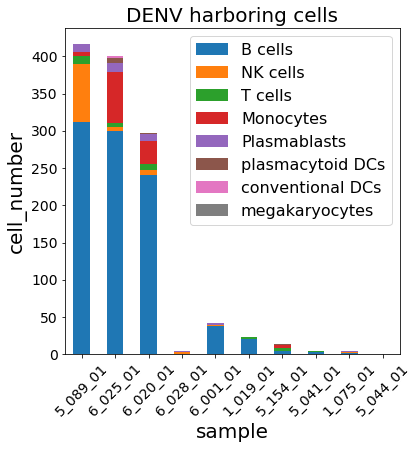

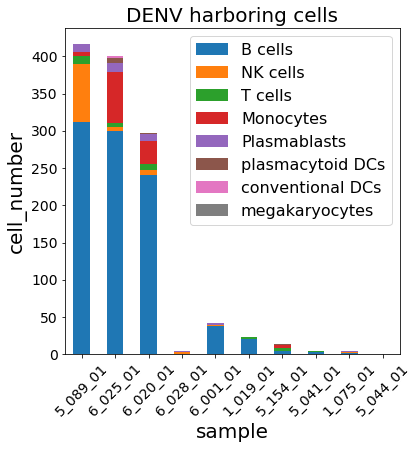

In [25]:
#calculating the numbers of VHC in each cell type and plot, Figure 2A (original Figure 1D)
df_info = info_df(data_kid)

path = '/Users/yzhiyuan/workspace/DENV_10X/figures/Manuscript/raw_figure_V4'
name_1 = 'stackbar.png'
name_2 = 'stackbar.pdf'
stackplot(df_info,path,name_1)
stackplot(df_info,path,name_2)

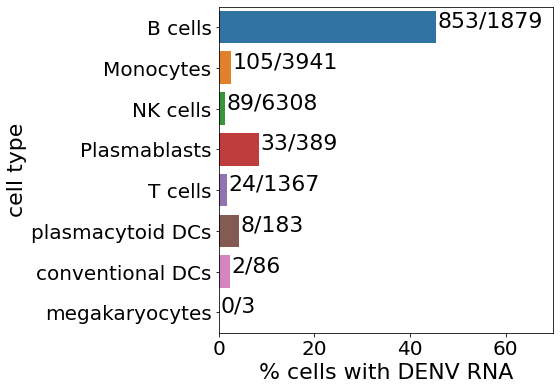

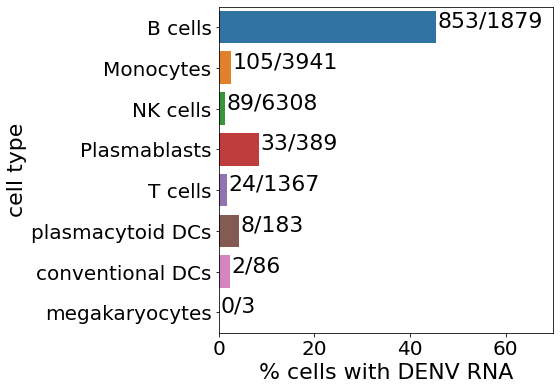

In [31]:
#For the VHC ratio panel in Figure 2B (original figure 1E)

#calculate the ratio and generate the table
df_merge = df_info_process(df_info, data_kid)

#plotting
path = '/Users/yzhiyuan/workspace/DENV_10X/figures/Manuscript/raw_figure_V4'
name_1 = 'fraction.png'
name_2 = 'fraction.pdf'
fraction_plotting(df_merge,path,name_1)
fraction_plotting(df_merge,path,name_2)